In [1]:
#Import packages
import pandas as pd
import numpy as np
import os

from functions import plotting_raw_data, error_plot, plot_cpt_data, plot_cpt_data_raw

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score
import xgboost as xgb

import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_param_importances, plot_optimization_history

c:\Users\haris\Documents\GitHub\ISGSR25_DataDrivenSiteCharacterization\DataDriven\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
######################## Define the text size of each plot globally ###########
SMALL_SIZE = 9
BIGGER_SIZE = 9

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "Times New Roman"
######################## Define the text size of each plot globally ###########

In [3]:
# =============================================================================
# Import CPT Dataset
# =============================================================================

# File path
file_path = r"..\data\database_preprocessed_2025_CPT_3.csv"

# Read the CSV file into a DataFrame
df_raw = pd.read_csv(file_path, low_memory=False)

df_raw['fs (MPa)'] = df_raw['fs (MPa)'] * 1000
df_raw.rename(columns={'fs (MPa)': 'fs (kPa)'}, inplace=True)
df_raw.rename(columns={'depth (m)': 'Depth (m)'}, inplace=True)

# Select only SCPTu data
df_SCPTu = df_raw[df_raw['test type'] == 'SCPTu']
# Select only SCPT data
df_SCPT = df_raw[df_raw['test type'] == 'SCPT']
# Select both SCPTu and SPT data
df_SCPTu_SCPT = df_raw[(df_raw['test type'] == 'SCPTu') | (df_raw['test type'] == 'SCPT')]

# Drop rows with missing Vs values
df_SCPTu_SCPT = df_SCPTu_SCPT.dropna(subset=['Vs (m/s)'])
df_SCPTu_SCPT = df_SCPTu_SCPT[df_SCPTu_SCPT['fs (kPa)'] >= 0]
df_SCPTu_SCPT = df_SCPTu_SCPT[df_SCPTu_SCPT['qc (MPa)'] >= 0]

# count number of tests in both subsets
SCPTu_number = df_SCPTu['ID'].nunique()
SCPT_number = df_SCPT['ID'].nunique()
combined_number = df_SCPTu_SCPT['ID'].nunique()

print('Preprocessing:\n')
print('Number of tests in SCPTu =', SCPTu_number)
print('Number of tests in SCPT =', SCPT_number)
print('Number of tests in SCPTu and SCPT =', combined_number)

Preprocessing:

Number of tests in SCPTu = 254
Number of tests in SCPT = 46
Number of tests in SCPTu and SCPT = 300


In [4]:
# Select columns
selected_columns_x = ['Depth (m)','qc (MPa)', 'fs (kPa)','Rf (%)','Vs (m/s)'] #for Machine learning features
plot_columns_x_label = ['Depth (m)','$q_c$ (MPa)', '$f_s$ (kPa)','$R_f$ (%)', '$v_s$ (m/s)'] #for plotting purpose

In [5]:
df_SCPTu_SCPT

,Dataset,ID,Depth (m),test type,qc (MPa),fs (kPa),Rf (%),u2 (MPa),Vs (m/s)
220034,9,1101,0.5,SCPT,4.760,157.1,3.300420,NaN,200.0
220084,9,1101,1.0,SCPT,1.650,73.5,4.454545,NaN,107.0
220134,9,1101,1.5,SCPT,3.570,47.4,1.327731,NaN,53.0
220184,9,1101,2.0,SCPT,0.440,34.8,7.909091,NaN,56.0
220234,9,1101,2.5,SCPT,0.340,30.5,8.970588,NaN,61.0
...,...,...,...,...,...,...,...,...,...
3069217,218970-Investigation-218970-240024_2 The Stran...,218970-Investigation-218970-240024_2 The Stran...,28.0,SCPTu,8.841,140.6,1.590318,4.4044,298.0
3069267,218970-Investigation-218970-240024_2 The Stran...,218970-Investigation-218970-240024_2 The Stran...,28.5,SCPTu,8.816,134.5,1.525635,4.4528,310.0
3069317,218970-Investigation-218970-240024_2 The Stran...,218970-Investigation-218970-240024_2 The Stran...,29.0,SCPTu,8.105,130.4,1.608883,4.3701,302.0
3069367,218970-Investigation-218970-240024_2 The Stran...,218970-Investigation-218970-240024_2 The Stran...,29.5,SCPTu,7.651,155.1,2.027186,3.3567,264.0


In [6]:
df_SCPTu_SCPT.describe()  # Descriptive statistics of the data

,Depth (m),qc (MPa),fs (kPa),Rf (%),u2 (MPa),Vs (m/s)
count,21760.000000,21760.000000,21760.000000,21760.000000,20154.000000,21760.000000
mean,15.557418,5.571092,65.407564,1.670000,0.786014,221.025747
std,9.682343,9.283922,97.807841,1.937735,44.233576,92.092364
min,0.050000,0.010000,0.000000,0.000000,-24.700000,0.000000
25%,7.777500,0.900000,9.697500,0.733047,0.001475,169.880000
50%,14.500000,1.610000,23.490000,1.143623,0.116560,214.680000
75%,22.300000,5.150000,76.500000,2.103573,0.499572,260.788293
max,59.795000,81.320000,1018.528000,101.000000,5610.300000,1310.000000


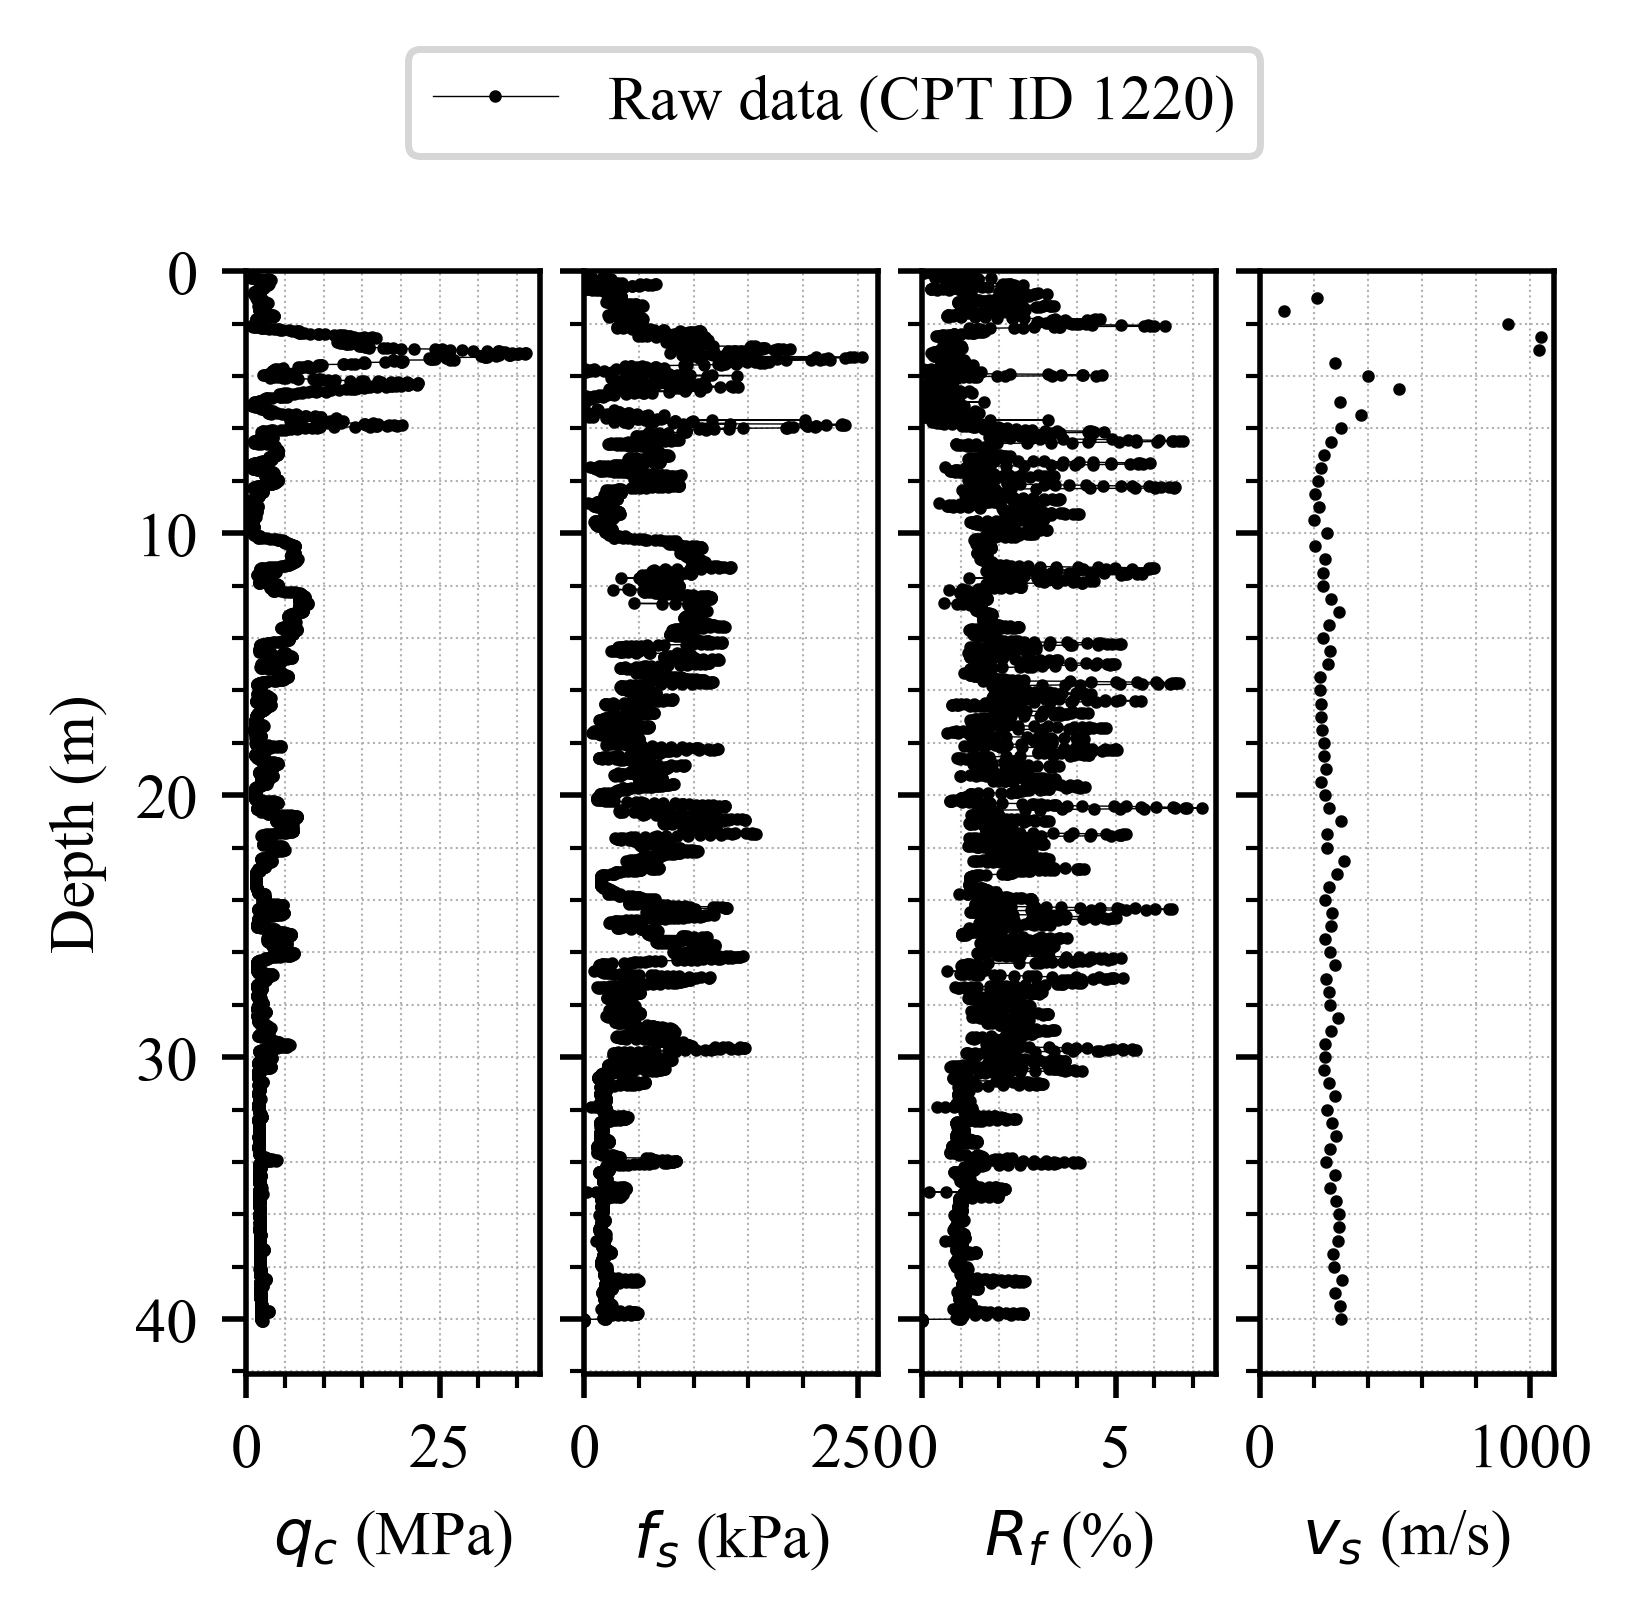

In [7]:
# =============================================================================
# Plotting the data and Selecting features
# =============================================================================
# Plotting CPT data 
cm = 1/2.54  # centimeters in inches

#Plot CPT: raw data and mean data
unique_ids = df_SCPTu_SCPT.loc[:,'ID'].unique()
id_value = np.random.choice(unique_ids)
fig, axes = plot_cpt_data_raw((8*cm, 8*cm), selected_columns_x, df_raw,
              id_value=id_value,
              plot_columns_x_label=plot_columns_x_label, sort_column='Depth (m)')

axes[0].legend(loc='upper center', bbox_to_anchor=(2.0, 1.23), ncol=1, handlelength = 2, labelspacing=0.1)
plt.subplots_adjust(left=0.15, right=0.98, top=0.85, bottom=0.15, wspace=0.15, hspace=0.2)


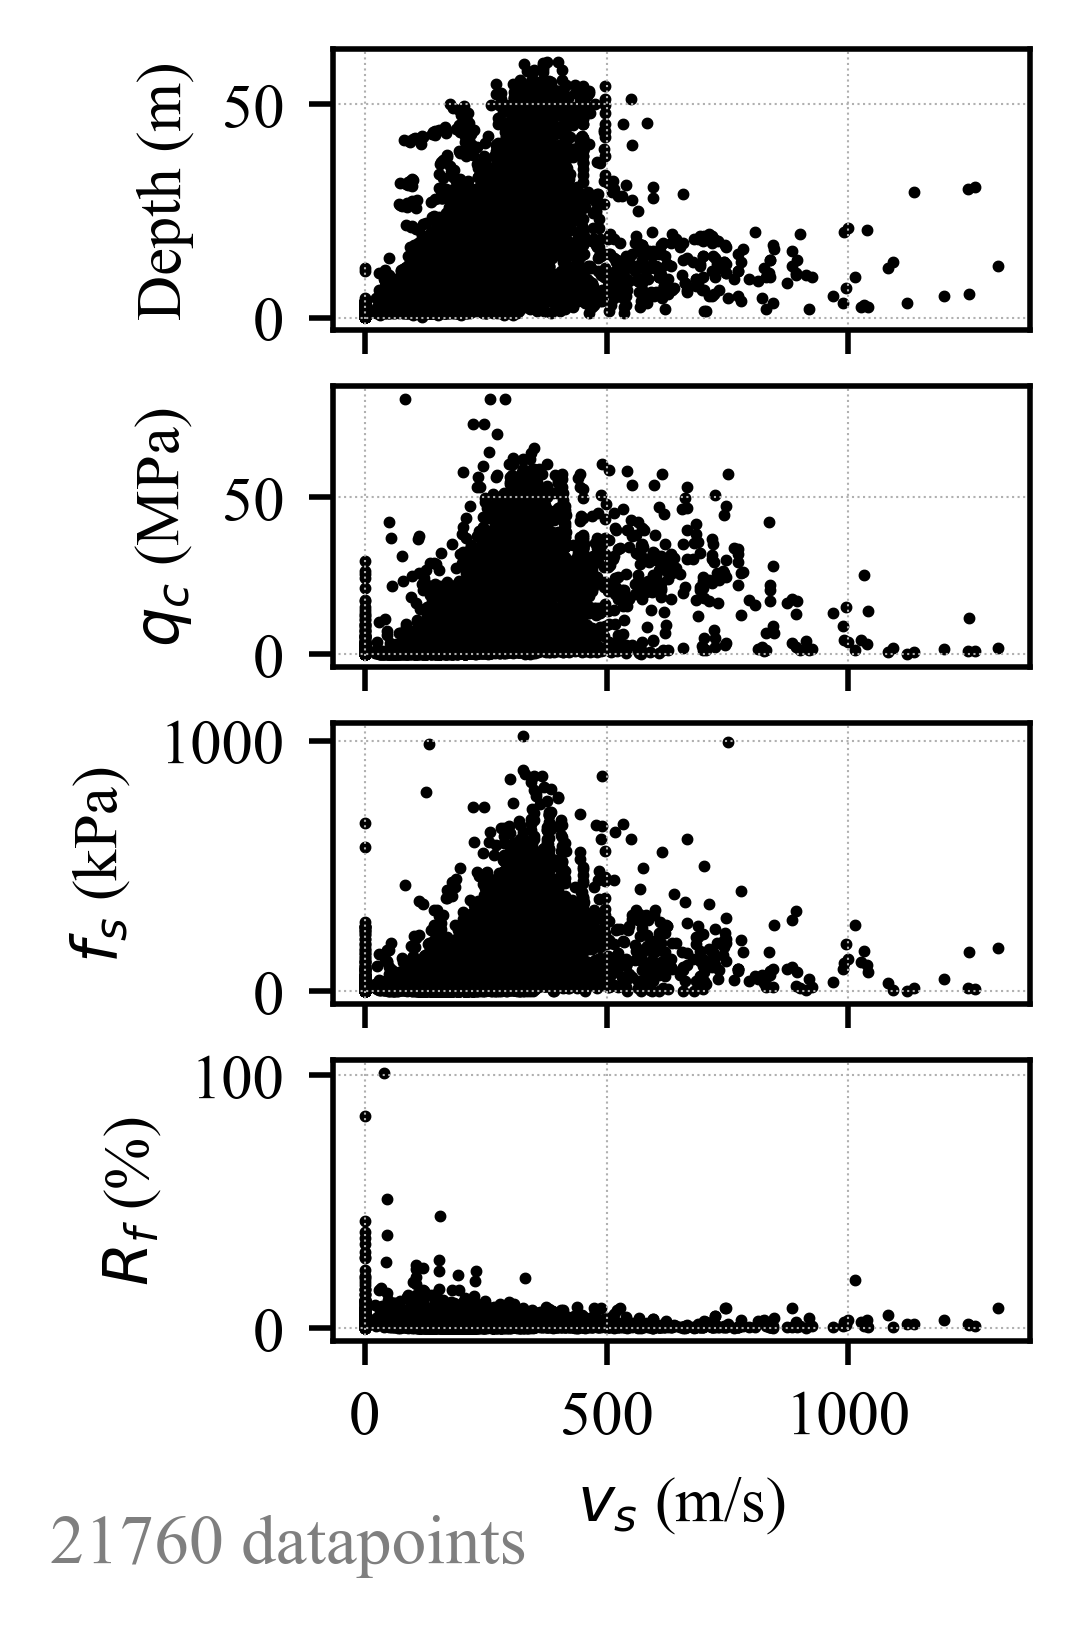

In [8]:
X = df_SCPTu_SCPT[selected_columns_x[:-1]]#.to_numpy()
y = df_SCPTu_SCPT['Vs (m/s)']#.to_numpy()

s = 0.5  # Adjust the marker size as needed
color = 'k'  # Adjust the marker color as needed
alpha = 1

#Plot scatter points: raw data points as
fig, axes = plt.subplots(4, 1, figsize=(15.4/3*cm, 8*cm), dpi=500, sharex=True)
plotting_raw_data(X,y, alpha, s, color, True, axes, plot_columns_x_label, 'Raw data', False)

# Adjust layout to prevent overlapping
fig.text(0.01, 0.02, rf'{len(df_SCPTu_SCPT)} datapoints', ha='left', va='center', fontsize=10, color='black', alpha=0.5)
plt.subplots_adjust(left=0.29, right=0.98, top=0.97, bottom=0.15, wspace=0.15, hspace=0.2)
plt.savefig("..\\graphics\\10_Raw_data.png", dpi = 1000)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [10]:
RS = 44  # random state
N_JOBS = -1  # number of parallel threads

# repeated K-folds
N_SPLITS = 10
N_REPEATS = 1

# XGBoost
EARLY_STOPPING_ROUNDS = 10

In [11]:
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.operators.sampling.lhs import LHS

from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.termination.default import DefaultSingleObjectiveTermination

class XGBRegressionProblem(Problem):
    def __init__(self, X, y, n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RS, n_jobs=-1):
        self.X = X.values
        self.y = y.values
        self.n_splits = n_splits
        self.n_repeats = n_repeats
        self.random_state = random_state
        self.n_jobs = n_jobs

        # Define bounds for hyperparameters
        bounds_lower = [50, 0.05, 3, 0.05, 0.01]
        bounds_upper = [150, 0.5, 10, 0.9, 2.0]

        super().__init__(n_var=5, n_obj=1, n_ieq_constr=0, xl=np.array(bounds_lower), xu=np.array(bounds_upper))

    def _evaluate(self, x, out, *args, **kwargs):
        results = []
        
        for params in x:
            n_estimators, learning_rate, max_depth, subsample, min_child_weight = params

            param = {
                "objective": "reg:squarederror",
                "tree_method": "hist",
                "n_estimators": int(n_estimators),
                "learning_rate": learning_rate,
                "max_depth": int(max_depth),
                "subsample": subsample,
                "min_child_weight": min_child_weight,
                "n_jobs": self.n_jobs,
            }

            model = xgb.XGBRegressor(**param, eval_metric="rmse", early_stopping_rounds = EARLY_STOPPING_ROUNDS)
            rkf = RepeatedKFold(n_splits=self.n_splits, n_repeats=self.n_repeats, random_state=self.random_state)

            y_pred = np.zeros_like(self.y)

            for train_index, test_index in rkf.split(self.X):
                X_train, X_test = self.X[train_index, :], self.X[test_index, :]
                y_train, y_test = self.y[train_index], self.y[test_index]

                model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)
                y_pred[test_index] += model.predict(X_test)

            y_pred /= self.n_repeats
            r2 = r2_score(self.y, y_pred)
            
            results.append(-r2)

        out["F"] = np.array(results)


problem = XGBRegressionProblem(X_train, y_train)

algorithm = DE(
    pop_size=25,
    sampling=LHS(),
)

termination = DefaultSingleObjectiveTermination(ftol=1e-4, n_max_evals=1000)

res = minimize(
    problem,
    algorithm,
    termination=termination,
    seed=1,
    save_history=True,
    verbose=True,
)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       25 | -5.277103E-01 | -5.515615E-01
     2 |       50 | -5.357526E-01 | -5.515615E-01
     3 |       75 | -5.408831E-01 | -5.515615E-01
     4 |      100 | -5.430417E-01 | -5.515615E-01
     5 |      125 | -5.447074E-01 | -5.523882E-01
     6 |      150 | -5.461653E-01 | -5.547704E-01
     7 |      175 | -5.489717E-01 | -5.547704E-01
     8 |      200 | -5.501624E-01 | -5.567423E-01
     9 |      225 | -5.516116E-01 | -5.581065E-01
    10 |      250 | -5.524382E-01 | -5.581065E-01
    11 |      275 | -5.529089E-01 | -5.581065E-01
    12 |      300 | -5.538104E-01 | -5.581075E-01
    13 |      325 | -5.544385E-01 | -5.583862E-01
    14 |      350 | -5.546750E-01 | -5.583862E-01
    15 |      375 | -5.548633E-01 | -5.583862E-01
    16 |      400 | -5.551263E-01 | -5.589268E-01
    17 |      425 | -5.556549E-01 | -5.589268E-01
    18 |      450 | -5.559127E-01 | -5.589268E-01
    19 |      475 | -5.559525E-01 | -5.589268E-01


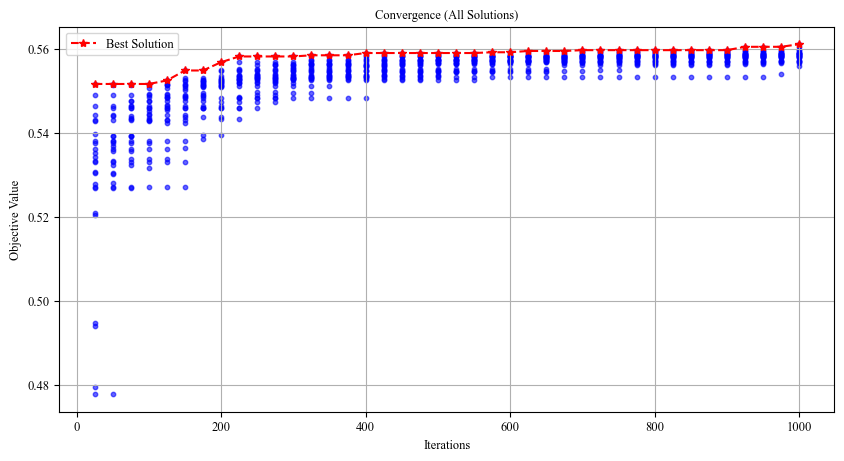

In [12]:
n_evals = []
all_opts = []

# Collect the evaluations and all objective values for each iteration
for e in res.history:
    n_evals.append(e.evaluator.n_eval)
    all_opts.append([sol.F for sol in e.pop])  # Collect all solutions' objectives

all_opts = np.array(all_opts)*(-1)


# Plotting
plt.figure(figsize=(10, 5))
# Plot each solution’s objective at each iteration
for i, opt_values in enumerate(all_opts):
    plt.scatter([n_evals[i]] * len(opt_values), opt_values, color='b', alpha=0.6, s=10)

# Plot the best solution per iteration
opt_best = np.array([e.opt[0].F for e in res.history]) * (-1)
plt.plot(n_evals, opt_best, "--*", color='r', label='Best Solution')

plt.title("Convergence (All Solutions)")
plt.xlabel('Iterations')
plt.ylabel('Objective Value')
plt.grid()
plt.legend()

In [13]:
# Extract the best parameters and objective value
best_params = {
    "n_estimators": int(res.X[0]),
    "learning_rate": res.X[1],
    "max_depth": int(res.X[2]),
    "subsample": res.X[3],
    "min_child_weight": res.X[4],
    "verbosity": 1,
    "objective": "reg:squarederror",
    "tree_method": "hist",
    "n_jobs": -1,  # Number of jobs
}

print("\nBest Parameters from DE Algorithm:")
for key, value in best_params.items():
    print(f"{key:>20s} : {value}")

best_r2 = -res.F[0]  # Convert back to positive R²
print(f"Best R²: {best_r2}")


Best Parameters from DE Algorithm:
        n_estimators : 140
       learning_rate : 0.05217328474254593
           max_depth : 9
           subsample : 0.6916968378530176
    min_child_weight : 0.5186566788794856
           verbosity : 1
           objective : reg:squarederror
         tree_method : hist
              n_jobs : -1
Best R²: 0.5610207326104844


In [14]:
model = xgb.XGBRegressor(**best_params, eval_metric="rmse",early_stopping_rounds = EARLY_STOPPING_ROUNDS)
rkf = RepeatedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RS)
X_values = X_train.values
y_values = y_train.values
y_pred = np.zeros_like(y_test.values)
for train_index, test_index in rkf.split(X_values):
    X_A, X_B = X_values[train_index, :], X_values[test_index, :]
    y_A, y_B = y_values[train_index], y_values[test_index]
    model.fit(
        X_A,
        y_A,
        eval_set=[(X_B, y_B)],
        verbose=0,
    )
    y_pred += model.predict(X_test.values) 
y_pred /= N_REPEATS * N_SPLITS

In [15]:
score, mse = r2_score(y_true=y_test, y_pred=y_pred), mean_squared_error(y_true=y_test, y_pred=y_pred)

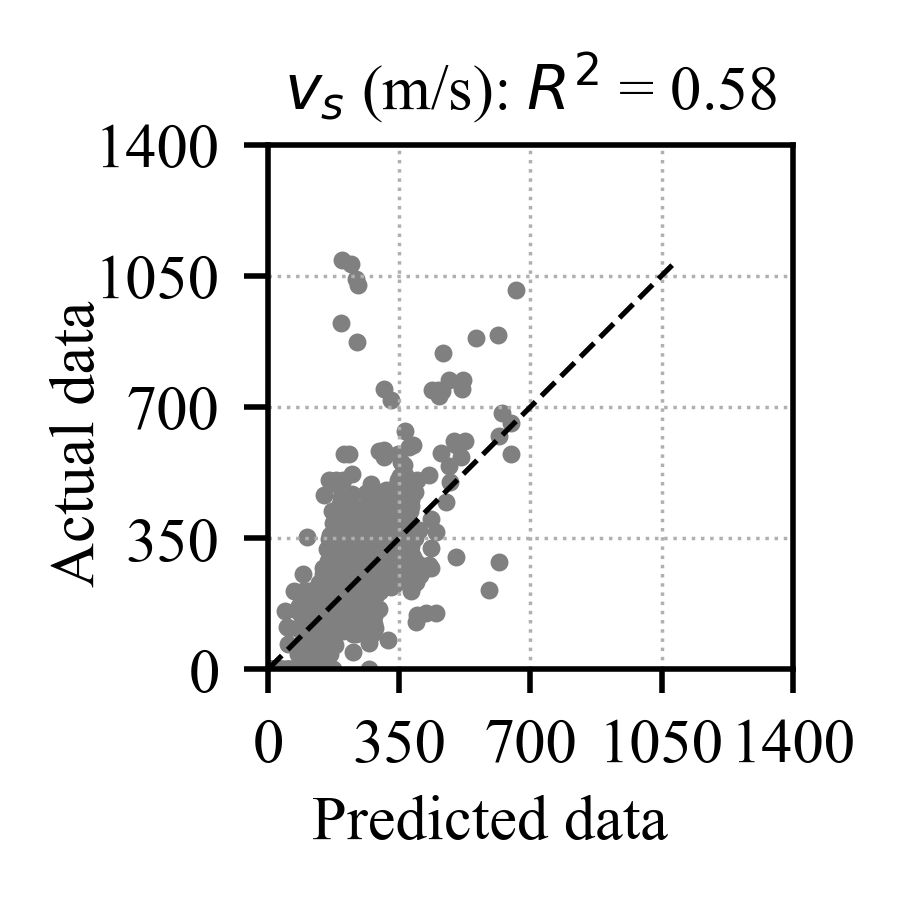

In [25]:
from sklearn.metrics import PredictionErrorDisplay

figsize= (15.4/3*cm, 15.4/3*cm)
l = 4.1 * cm
figsize= (l, l)
# figsize=(15.92/3*cm, 15.92/3*cm)

y_true = y_test
y_pred = pd.DataFrame(y_pred)


# Define plot structure
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=figsize, dpi=500)

ped = PredictionErrorDisplay.from_predictions(y_true=y_true,
                                            y_pred=y_pred,
                                            kind="actual_vs_predicted",
                                            subsample=100000,
                                            ax=axs,
                                            random_state=0, 
                                            line_kwargs={"color": "black", "linewidth": 0.75, "linestyle": "--", "alpha": 1},)

ped.ax_.set_xlabel("")  # Set x label
ped.ax_.set_ylabel("")  # Set y label

xlim, ylim = 0,1400

ped.ax_.set_xticks(np.arange(xlim, ylim+0.001, (ylim-xlim)/4))
ped.ax_.set_yticks(np.arange(xlim, ylim+0.001, (ylim-xlim)/4))
# ped.ax_.set_xlim(xlim+0.001, ylim-0.001)
# ped.ax_.set_ylim(xlim+0.001, ylim-0.001)
ped.ax_.set_xlim(xlim)
ped.ax_.set_ylim(xlim)

ped.ax_.grid(linewidth = 0.5, linestyle = 'dotted')

scatter = ped.figure_.axes[0].collections[0]
scatter.set_color('gray')  
scatter.set_sizes([2.5]) 
scatter.set_alpha([1]) 

# plt.title(f'{investigated_column_plot}: $R^2$ = {score:.2f}, $MSE$ = {mse:.2f}', x = 0.41, y=1.02)
plt.title(f'{plot_columns_x_label[-1]}: $R^2$ = {score:.2f}', x = 0.5, y=0.99)


ax = ped.ax_
ax.set_xticks(ax.get_xticks())
ax.tick_params(axis='x', rotation=0)

fig.text(0.55, 0.03, r'Predicted data', ha='center', va='center')
fig.text(0.04, 0.5, r'Actual data', ha='center', va='center', rotation='vertical')

plt.subplots_adjust(left=0.275, right=0.925, top=0.87, bottom=0.22, wspace=0.5, hspace=0.5)

save_path = r'..\graphics\\10_vs_prediction.png'
plt.savefig(save_path, dpi=1000)

In [17]:
# Save the model using joblib or pickle
import joblib

# Fit the model on the entire dataset with the best hyperparameters
final_model = xgb.XGBRegressor(**best_params, eval_metric="rmse", random_state=RS)

# Fit the model on the entire dataset
final_model.fit(X, y)

joblib.dump(final_model, f'10_vs_prediction_xgb_model.joblib')


['10_vs_prediction_xgb_model.joblib']